<a href="https://colab.research.google.com/github/rickiepark/MLQandAI/blob/main/supplementary/q19-evaluation-llms/BERTScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTScore

In [1]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def bert_score(reference, candidate, return_similarity_matrix=False):

    # BERT 토크나이저와 모델을 로드합니다.
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased")

    # 입력 텍스트를 토큰화합니다.
    ref_tokens = tokenizer(reference, return_tensors="pt", add_special_tokens=False)
    can_tokens = tokenizer(candidate, return_tensors="pt", add_special_tokens=False)

    # BERT 임베딩을 추출합니다.
    model.eval()
    with torch.no_grad():
        ref_outputs = model(**ref_tokens)
        ref_embeddings = ref_outputs.last_hidden_state[0]

        can_outputs = model(**can_tokens)
        can_embeddings = can_outputs.last_hidden_state[0]

    # 코사인 유사도를 계산합니다.
    cosine_similarities = np.zeros((can_embeddings.shape[0], ref_embeddings.shape[0]))
    for i, c in enumerate(can_embeddings):
        for j, r in enumerate(ref_embeddings):
            cosine_similarities[i, j] = cosine_similarity(c, r)


    # 코사인 유사도를 정렬합니다.
    max_similarities = cosine_similarities.max(axis=1)

    # 유사도 점수를 평균합니다.
    bertscore = max_similarities.mean()

    if return_similarity_matrix:
        return bertscore, cosine_similarities
    else:
        return bertscore

In [2]:
# 입력 텍스트를 정의합니다.
reference = "The quick brown fox jumps over the lazy dog."
candidate = "A quick brown fox leaps over a dog."

bert_score(reference, candidate)

0.8767203622394137

In [3]:
bert_score("fast", "quick")

0.6320915818214417

In [4]:
bert_score("fast", "fast")

1.0000001192092896

In [5]:
reference = "The cat jumped"
candidate = "A cat leaped high"

# BERTScore를 계산합니다.
bertscore, sim_matrix = bert_score(
    reference, candidate, return_similarity_matrix=True)

print(bertscore)
print(sim_matrix)

0.6859036386013031
[[0.63398367 0.52621484 0.51968843]
 [0.59454829 0.71506655 0.6889143 ]
 [0.55240417 0.68978482 0.69811267]
 [0.55321139 0.69165015 0.69645166]]


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap(
    matrix,
    hide_spines=False,
    hide_ticks=False,
    figsize=None,
    cmap=None,
    colorbar=True,
    row_names=None,
    column_names=None,
    column_name_rotation=45,
    cell_values=True,
    cell_fmt=".2f",
    cell_font_size=None,
):

    if row_names is not None and len(row_names) != matrix.shape[0]:
        raise AssertionError(
            f"len(row_names) (got {len(row_names)})"
            " should be equal to number of"
            " rows in the input "
            f" array (expect {matrix.shape[0]})."
        )

    if column_names is not None and len(column_names) != matrix.shape[1]:
        raise AssertionError(
            f"len(column_names)"
            " (got {len(column_names)})"
            " should be equal to number of"
            " columns in the"
            f" input array (expect {matrix.shape[1]})."
        )

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)

    if cmap is None:
        cmap = plt.cm.viridis

    if figsize is None:
        figsize = (len(matrix) * 1.5, len(matrix) * 1.5)

    matshow = ax.matshow(matrix, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    normed_matrix = matrix.astype("float") / matrix.max()

    if cell_values:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                cell_text = format(matrix[i, j], cell_fmt)

                ax.text(
                    x=j,
                    y=i,
                    size=cell_font_size,
                    s=cell_text,
                    va="center",
                    ha="center",
                    color="black"
                    if normed_matrix[i, j] > np.max(normed_matrix) / 2
                    else "black",
                )

    if row_names is not None:
        tick_marks = np.arange(len(row_names))
        plt.yticks(tick_marks, row_names)

    if column_names is not None:
        tick_marks = np.arange(len(column_names))

        if column_name_rotation:
            plt.xticks(
                tick_marks,
                column_names,
                rotation=column_name_rotation,
                ha="right",
                rotation_mode="anchor",
            )
        else:
            plt.xticks(tick_marks, column_names)

    if hide_spines:
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    return fig, ax

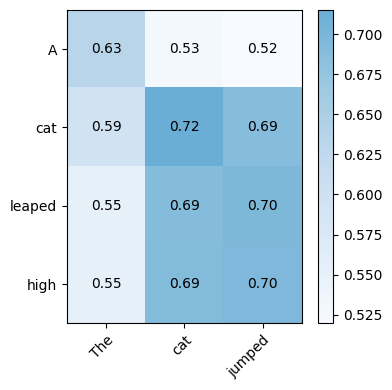

In [7]:
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

viridisBig = colormaps['Blues']
newcmp = ListedColormap(viridisBig(np.linspace(0.0, 0.5, 256)))

fig, ax = heatmap(sim_matrix, column_names=reference.split(),
                  row_names=candidate.split(), cmap=newcmp, figsize=(4, 4))

plt.tight_layout()

#plt.savefig('matrix.pdf')
plt.show()

# 공식 BERTScore 패키지 사용하기

참고: https://github.com/Tiiiger/bert_score

In [8]:
!pip install bert-score

In [9]:
import torch
from bert_score import score

# 참조 텍스트와 후보 텍스를 정의합니다.
reference = "The quick brown fox jumps over the lazy dog."
candidate = "A quick brown fox leaps over a lazy dog."

# BERTScore(P, R, F1)를 계산합니다.
P, R, F1 = score([candidate], [reference], lang='en', model_type='bert-base-uncased',
                 device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# BERTScore 결과를 출력합니다.
print(f"정밀도: {P.item():.4f}")
print(f"재현율: {R.item():.4f}")
print(f"F1 점수: {F1.item():.4f}")

정밀도: 0.9040
재현율: 0.9040
F1 점수: 0.9040
